# Double Jet

With various grid sizes

In [1]:
from gpuocean.utils import Common, IPythonMagic

from importlib import reload

import numpy as np
import copy
import pycuda.driver as cuda
from matplotlib import pyplot as plt

# plt.style.use('dark_background')

plt.rcParams["image.origin"] = "lower"


In [2]:
%cuda_context_handler gpu_ctx

In [3]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.DoubleJetPlot import *

Get initial arguments from class

In [4]:
from gpuocean.utils import DoubleJetCase

In [5]:
doubleJetCase = DoubleJetCase.DoubleJetCase(gpu_ctx, DoubleJetCase.DoubleJetPerturbationType.SteadyState, ny=256, nx=512)
doubleJetCase_args, doubleJetCase_init, _ = doubleJetCase.getInitConditions()

## Truth

In [6]:
truth_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/DoubleJetTruth/2023-11-02T09_33_29"

true_state = np.load(os.path.join(truth_path, "truth_864000.npy"))

## Ensembles

In [7]:
from utils.DoubleJetSL import *

In [8]:
def ML_from_path(mlda_path): 

    ML_state = []
    ML_state.append(np.load(mlda_path+"/MLstates/MLensemble_0.npy"))

    numLevels = len(set([f.split("_")[1][0] for f in os.listdir(mlda_path+"/MLstates")]))
    for l_idx in range(1, numLevels):
        ML_state.append( [np.load(mlda_path+"/MLstates/MLensemble_"+str(l_idx)+"_0.npy"), np.load(mlda_path+"/MLstates/MLensemble_"+str(l_idx)+"_1.npy")] )

    return ML_state

In [9]:
mlda0_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/DoubleJetMLDA/2023-11-08T16_32_29"
ML0_state = ML_from_path(mlda0_path)

In [10]:
mlda1_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/DoubleJetMLDA/2023-11-13T14_29_01"
ML1_state = ML_from_path(mlda1_path)

In [11]:
Ts = np.arange(0, 13*24*3600, 900)/(24*3600)

In [20]:
c0 = (0, 68/255, 136/255)
c1 = (238/255, 119/255, 51/255)

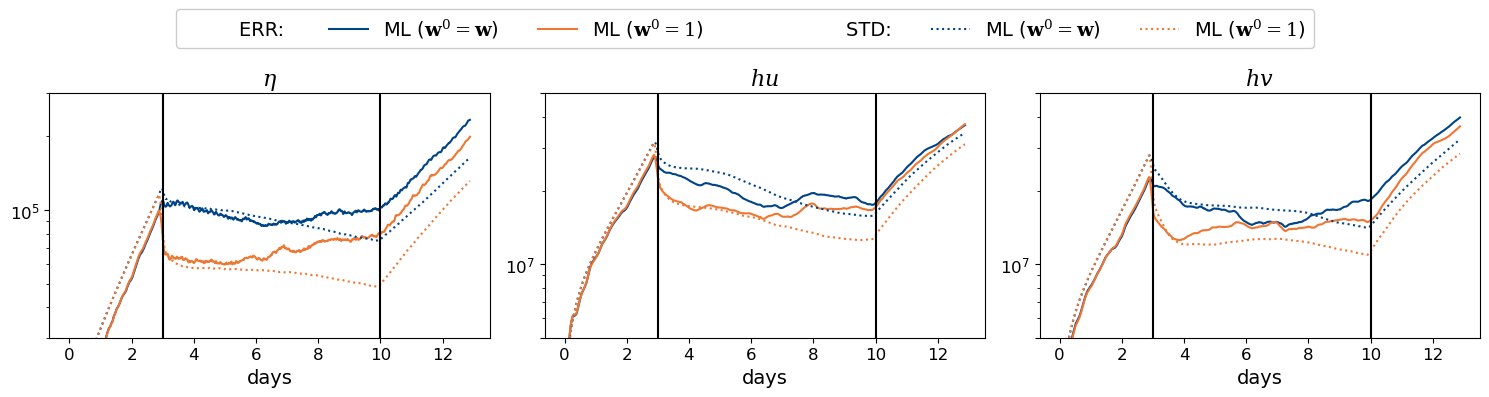

In [35]:
fig, axs = plt.subplots(1,3, figsize=(15,3.5))
plt.rcParams["mathtext.fontset"] = "dejavuserif"

ml0_rmse = np.load(mlda0_path + "/MLrmses_posterior.npy")
ml1_rmse = np.load(mlda1_path + "/MLrmses_posterior.npy")

ml0_std = np.load(mlda0_path + "/MLstddevs_posterior.npy")
ml1_std = np.load(mlda1_path + "/MLstddevs_posterior.npy")

for i in range(3):
    axs[i].set_yscale("log")

    N=12
    axs[i].plot(Ts[:-N+1], np.convolve(ml0_rmse[:,i], np.ones(N)/N, mode="valid"), c=c0,  label=r"ML ($\mathbf{w}^0 = \mathbf{w}$)")
    axs[i].plot(Ts[:-N+1], np.convolve(ml1_rmse[:,i], np.ones(N)/N, mode="valid"), c=c1,  label=r"ML ($\mathbf{w}^0 = 1$)")

    axs[i].plot(Ts[:-N+1], np.convolve(ml0_std[:,i], np.ones(N)/N, mode="valid"), c=c0, ls="dotted", label=r"ML ($\mathbf{w}^0 = \mathbf{w}$)")
    axs[i].plot(Ts[:-N+1], np.convolve(ml1_std[:,i], np.ones(N)/N, mode="valid"), c=c1, ls="dotted", label=r"ML ($\mathbf{w}^0 = 1$)")

    axs[i].axvline(3, c="black")
    axs[i].axvline(10, c="black")

    axs[i].tick_params(axis='x', labelsize=12)
    axs[i].tick_params(axis='y', labelsize=12)
    axs[i].set_xlabel("days", fontsize=14)
    
    if i == 0:
        axs[i].set_ylim((3e4, 3e5))
        plt.setp(axs[i].get_yminorticklabels(), visible=False)
    else:
        axs[i].set_ylim((5e6, 5e7))
        axs[i].set_yticks([5e6, 1e7, 5e7])
        plt.setp(axs[i].get_yminorticklabels(), visible=False)


# https://stackoverflow.com/questions/44071525/matplotlib-add-titles-to-the-legend-rows
h, l = axs[i].get_legend_handles_labels()
ph = [plt.plot([],marker="", ls="")[0]]*2

handles = ph[:1] + h[:2] + ph[1:] + h[2:]
labels = ["ERR: "] + l[:2] + ["        STD:"] + l[2:]

leg = fig.legend(handles, labels, loc="upper center", ncol=10, bbox_to_anchor=(0.5, 1.15), framealpha=1.0, fontsize=14)

# for vpack in leg._legend_handle_box.get_children():
#     for hpack in vpack.get_children()[:1]:
#         hpack.get_children()[0].set_width(0)

axs[0].set_title(r"$\eta$", fontsize=16)
axs[1].set_title(r"$hu$", fontsize=16)
axs[2].set_title(r"$hv$", fontsize=16)

for ax in axs:
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)


plt.tight_layout()

plt.savefig("DoubleJet-DA-PostProcessing-ERRloc4paper.pdf", bbox_inches="tight", dpi=300)